# 🧠 Deep Learning Trading Model Trainer

Train a neural network to predict trading signals (BUY/SELL/HOLD) from:
- Technical Indicators (RSI, MACD, EMA, ADX, ATR, etc.)
- Candlestick Patterns
- Price Patterns (Double Top, Head & Shoulders, etc.)
- Support/Resistance levels
- News sentiment

**Data Source**: 1,077 JSON files in `ai_training_pending/`

In [1]:
# 1. Import Required Libraries
import sys
import os
import json
import glob
import numpy as np
from pathlib import Path
from datetime import datetime

# Add project to path
sys.path.insert(0, os.getcwd())

# Check dependencies
print("📦 Checking dependencies...")

try:
    import torch
    print(f"✅ PyTorch: {torch.__version__}")
    print(f"   CUDA: {'Available - ' + torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Not available (CPU mode)'}")
    USE_TORCH = True
except ImportError:
    print("⚠️ PyTorch not installed - using sklearn")
    USE_TORCH = False

try:
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
    import joblib
    print("✅ Scikit-learn available")
except ImportError:
    print("❌ Scikit-learn not installed!")

print("\n✅ All imports successful!")

📦 Checking dependencies...
✅ PyTorch: 2.9.1+cpu
   CUDA: Not available (CPU mode)
✅ PyTorch: 2.9.1+cpu
   CUDA: Not available (CPU mode)
✅ Scikit-learn available

✅ All imports successful!
✅ Scikit-learn available

✅ All imports successful!


## 2. Load Feature Extractor

Load the custom feature extractor that converts JSON trading data into numerical features.

In [2]:
# Load feature extractor
from ai_models.feature_extractor import FeatureExtractor

extractor = FeatureExtractor()
print(f"📊 Feature count: {extractor.feature_count}")
print(f"📋 Feature names: {extractor.get_feature_names()[:10]}...")

📊 Feature count: 43
📋 Feature names: ['rsi_m15', 'stoch_k_m15', 'macd_m15', 'macd_signal_m15', 'macd_hist_m15', 'adx_m15', 'atr_m15', 'bb_position_m15', 'rsi_h1', 'stoch_k_h1']...


## 3. Load Training Data

Load all JSON files from `ai_training_pending/` and extract features.

In [3]:
# 3. Load Training Data
SIGNAL_MAP = {'SELL': 0, 'HOLD': 1, 'BUY': 2}
SIGNAL_MAP_REVERSE = {0: 'SELL', 1: 'HOLD', 2: 'BUY'}

pending_dir = Path("ai_training_pending")
files = list(pending_dir.glob("*.json"))
print(f"📂 Found {len(files)} files in {pending_dir}")

X_list = []
y_list = []
symbols_seen = set()

for i, file in enumerate(files):
    try:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        features, signal_type, confidence = extractor.extract_from_pending_file(str(file))
        
        if features is not None and signal_type is not None and confidence >= 40:
            X_list.append(features)
            y_list.append(SIGNAL_MAP.get(signal_type, 1))
            symbols_seen.add(data.get('symbol', 'unknown'))
        
        if (i + 1) % 200 == 0:
            print(f"  Processed {i+1}/{len(files)}...")
            
    except Exception as e:
        pass

X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.int64)

# Handle NaN/Inf
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\n✅ Data loaded!")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Symbols: {symbols_seen}")
print(f"\n📊 Class distribution:")
print(f"   SELL: {np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%)")
print(f"   HOLD: {np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")
print(f"   BUY:  {np.sum(y==2)} ({np.sum(y==2)/len(y)*100:.1f}%)")

📂 Found 1077 files in ai_training_pending
  Processed 200/1077...
  Processed 200/1077...
  Processed 400/1077...
  Processed 400/1077...
  Processed 600/1077...
  Processed 600/1077...
  Processed 800/1077...
  Processed 800/1077...
  Processed 1000/1077...
  Processed 1000/1077...

✅ Data loaded!
   X shape: (1077, 43)
   y shape: (1077,)
   Symbols: {'BNBUSD_m', 'XAUUSD.', 'EURUSD.', 'LTCUSD_m', 'GBPUSD.', 'SOLUSD_m'}

📊 Class distribution:
   SELL: 45 (4.2%)
   HOLD: 1029 (95.5%)
   BUY:  3 (0.3%)

✅ Data loaded!
   X shape: (1077, 43)
   y shape: (1077,)
   Symbols: {'BNBUSD_m', 'XAUUSD.', 'EURUSD.', 'LTCUSD_m', 'GBPUSD.', 'SOLUSD_m'}

📊 Class distribution:
   SELL: 45 (4.2%)
   HOLD: 1029 (95.5%)
   BUY:  3 (0.3%)


## 4. Data Preprocessing

Scale features and split into train/test sets.

In [4]:
# 4. Data Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Data Split:")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

📊 Data Split:
   Train: 861 samples
   Test:  216 samples


## 5. Build Neural Network Model (PyTorch)

Create a deep neural network with:
- Input: 42 features
- Hidden layers: 128 → 64 → 32 (with BatchNorm & Dropout)
- Output: 3 classes (SELL, HOLD, BUY)

In [5]:
# 5. Build Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class TradingNN(nn.Module):
    def __init__(self, n_features, n_classes=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32, n_classes)
        )
    
    def forward(self, x):
        return self.network(x)

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_features = X_train.shape[1]
model = TradingNN(n_features, n_classes=3).to(device)

print(f"🧠 Model created!")
print(f"   Device: {device}")
print(f"   Input features: {n_features}")
print(f"   Architecture:")
print(model)

🧠 Model created!
   Device: cpu
   Input features: 43
   Architecture:
TradingNN(
  (network): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=3, bias=True)
  )
)


## 6. Train the Model

Train for 100 epochs with early stopping.

In [6]:
# 6. Train the Model
# Prepare data loaders
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.LongTensor(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class weights for imbalanced data
class_counts = np.bincount(y_train, minlength=3)
class_weights = 1.0 / (class_counts + 1)
class_weights = class_weights / class_weights.sum() * 3
weights = torch.FloatTensor(class_weights).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Training loop
EPOCHS = 100
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
patience_counter = 0

print("🏋️ Training started...")
print("-" * 60)

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    
    # Validate
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()
    
    val_loss /= len(test_loader)
    val_acc = val_correct / val_total
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if patience_counter >= 20:
        print(f"\n⏹️ Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
print("-" * 60)
print(f"✅ Training completed! Best Val Loss: {best_val_loss:.4f}")

🏋️ Training started...
------------------------------------------------------------
Epoch  10/100 | Train Loss: 0.3469 | Train Acc: 0.9233 | Val Loss: 0.2140 | Val Acc: 0.9444
Epoch  10/100 | Train Loss: 0.3469 | Train Acc: 0.9233 | Val Loss: 0.2140 | Val Acc: 0.9444
Epoch  20/100 | Train Loss: 0.2041 | Train Acc: 0.9338 | Val Loss: 0.1262 | Val Acc: 0.9352
Epoch  20/100 | Train Loss: 0.2041 | Train Acc: 0.9338 | Val Loss: 0.1262 | Val Acc: 0.9352
Epoch  30/100 | Train Loss: 0.1721 | Train Acc: 0.9466 | Val Loss: 0.0565 | Val Acc: 0.9769
Epoch  30/100 | Train Loss: 0.1721 | Train Acc: 0.9466 | Val Loss: 0.0565 | Val Acc: 0.9769
Epoch  40/100 | Train Loss: 0.1165 | Train Acc: 0.9663 | Val Loss: 0.0804 | Val Acc: 0.9444
Epoch  40/100 | Train Loss: 0.1165 | Train Acc: 0.9663 | Val Loss: 0.0804 | Val Acc: 0.9444
Epoch  50/100 | Train Loss: 0.1192 | Train Acc: 0.9652 | Val Loss: 0.0365 | Val Acc: 0.9861
Epoch  50/100 | Train Loss: 0.1192 | Train Acc: 0.9652 | Val Loss: 0.0365 | Val Acc: 0.9

## 7. Evaluate Model Performance

In [7]:
# 7. Evaluate Model
model.eval()
with torch.no_grad():
    X_test_device = X_test_t.to(device)
    outputs = model(X_test_device)
    _, y_pred = outputs.max(1)
    y_pred = y_pred.cpu().numpy()

print("📊 Classification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred, target_names=['SELL', 'HOLD', 'BUY']))

print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"          SELL  HOLD  BUY")
print(f"SELL    {cm[0][0]:5d} {cm[0][1]:5d} {cm[0][2]:5d}")
print(f"HOLD    {cm[1][0]:5d} {cm[1][1]:5d} {cm[1][2]:5d}")
print(f"BUY     {cm[2][0]:5d} {cm[2][1]:5d} {cm[2][2]:5d}")

print(f"\n✅ Final Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

📊 Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

        SELL       0.56      1.00      0.72         9
        HOLD       1.00      0.97      0.98       206
         BUY       1.00      1.00      1.00         1

    accuracy                           0.97       216
   macro avg       0.85      0.99      0.90       216
weighted avg       0.98      0.97      0.97       216


📊 Confusion Matrix:
          SELL  HOLD  BUY
SELL        9     0     0
HOLD        7   199     0
BUY         0     0     1

✅ Final Accuracy: 96.76%


## 8. Visualize Training History

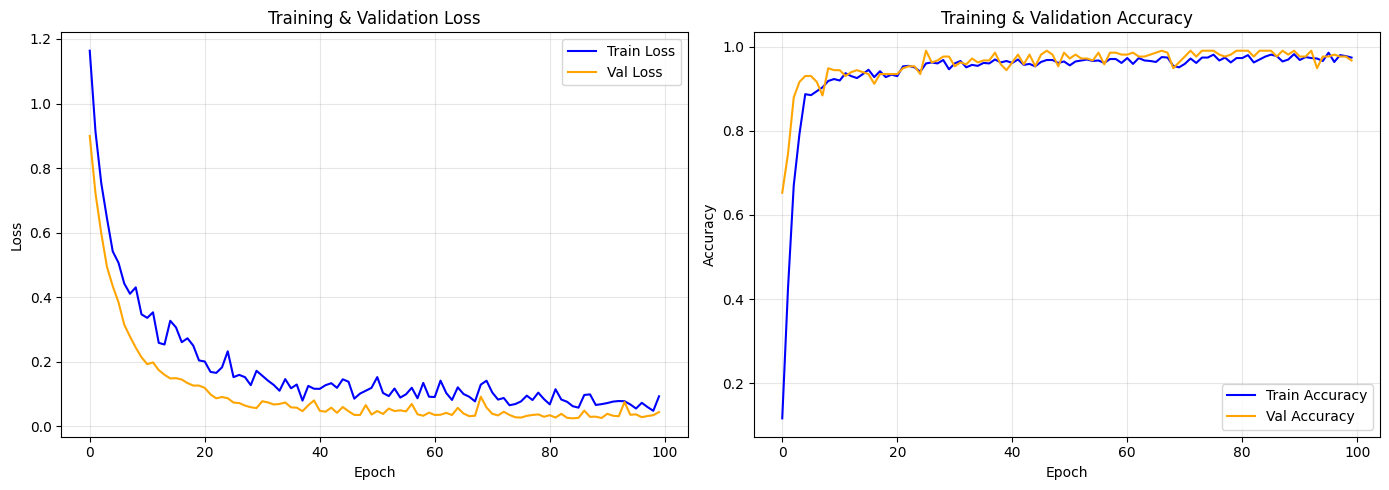


📈 Best Validation Accuracy: 99.07%


In [8]:
# 8. Visualize Training History
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', color='blue')
axes[1].plot(history['val_acc'], label='Val Accuracy', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training & Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Best Validation Accuracy: {max(history['val_acc'])*100:.2f}%")

## 9. Save Model

Save the trained model for use in `comprehensive_aggregator.py`

In [9]:
# 9. Save Model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = Path(f"ai_models/trained/trading_model_{timestamp}")
save_dir.mkdir(parents=True, exist_ok=True)

# Save PyTorch model
torch.save({
    'model_state_dict': model.state_dict(),
    'n_features': n_features,
    'training_history': history,
}, save_dir / 'model.pt')

# Save scaler
joblib.dump(scaler, save_dir / 'scaler.joblib')

# Save config
config = {
    'n_features': n_features,
    'feature_names': extractor.get_feature_names(),
    'use_torch': True,
    'training_history': history,
    'created_at': timestamp,
    'signal_map': SIGNAL_MAP,
    'final_accuracy': accuracy_score(y_test, y_pred),
    'class_distribution': {
        'SELL': int(np.sum(y==0)),
        'HOLD': int(np.sum(y==1)),
        'BUY': int(np.sum(y==2))
    }
}
with open(save_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

# Update latest pointer
with open('ai_models/trained/latest.txt', 'w') as f:
    f.write(str(save_dir))

print(f"✅ Model saved to: {save_dir}")
print(f"\n📋 Files saved:")
for f in save_dir.glob("*"):
    print(f"   - {f.name}")

✅ Model saved to: ai_models\trained\trading_model_20251206_142159

📋 Files saved:
   - config.json
   - model.pt
   - scaler.joblib


## 10. Test Prediction

Test the model with a sample prediction.

In [10]:
# 10. Test Prediction
def predict_signal(features):
    """Predict trading signal from features"""
    model.eval()
    with torch.no_grad():
        # Scale features
        features_scaled = scaler.transform(features.reshape(1, -1))
        x = torch.FloatTensor(features_scaled).to(device)
        
        # Get prediction
        outputs = model(x)
        proba = torch.softmax(outputs, dim=1).cpu().numpy()[0]
        pred_class = np.argmax(proba)
        
        signal = SIGNAL_MAP_REVERSE[pred_class]
        confidence = proba[pred_class] * 100
        
        return signal, confidence, {
            'SELL': proba[0] * 100,
            'HOLD': proba[1] * 100,
            'BUY': proba[2] * 100
        }

# Test with a random sample
test_idx = np.random.randint(0, len(X_test))
test_features = X[test_idx]  # Use unscaled features
actual = SIGNAL_MAP_REVERSE[y[test_idx]]

signal, confidence, proba = predict_signal(test_features)

print("🔮 Sample Prediction:")
print(f"   Actual: {actual}")
print(f"   Predicted: {signal} ({confidence:.1f}%)")
print(f"   Probabilities:")
print(f"      SELL: {proba['SELL']:.1f}%")
print(f"      HOLD: {proba['HOLD']:.1f}%")
print(f"      BUY:  {proba['BUY']:.1f}%")

🔮 Sample Prediction:
   Actual: HOLD
   Predicted: HOLD (99.6%)
   Probabilities:
      SELL: 0.3%
      HOLD: 99.6%
      BUY:  0.1%


## ✅ Done!

Model đã được train và lưu. Để sử dụng trong `comprehensive_aggregator.py`:

```python
from ai_models.ml_signal_predictor import get_ml_predictor

predictor = get_ml_predictor()
signal, confidence, proba = predictor.predict(data)

# Hoặc combine với rule-based
final_signal, final_conf = predictor.combine_signals(rule_signal, rule_conf, ml_signal, ml_conf)
```

### Files tạo ra:
- `ai_models/feature_extractor.py` - Trích xuất features từ data
- `ai_models/deep_learning_model.py` - Neural Network model
- `ai_models/ml_signal_predictor.py` - Wrapper để integrate
- `ai_models/trained/` - Thư mục chứa model đã train

## 🔄 Re-train với Sideway Data

Model cần học thêm logic Sideway trading:
- **Gần Support (0-30%)** → BUY
- **Giữa (30-70%)** → HOLD
- **Gần Resistance (70-100%)** → SELL

In [11]:
# Reload feature extractor (với sideway features mới)
import importlib
import ai_models.feature_extractor as fe
importlib.reload(fe)
from ai_models.feature_extractor import FeatureExtractor

extractor = FeatureExtractor()
print(f"📊 Updated feature count: {extractor.feature_count}")
print(f"🆕 New features include: is_sideway, position_in_range, sideway_signal")

📊 Updated feature count: 43
🆕 New features include: is_sideway, position_in_range, sideway_signal


In [12]:
# Load ALL data (1577 files: 1077 original + 500 sideway)
pending_dir = Path("ai_training_pending")
files = list(pending_dir.glob("*.json"))
print(f"📂 Found {len(files)} training files")

# Count sideway vs original
sideway_files = [f for f in files if 'sideway' in f.name.lower()]
print(f"   - Original: {len(files) - len(sideway_files)}")
print(f"   - Sideway:  {len(sideway_files)}")

X_list = []
y_list = []
symbols_seen = set()

for i, file in enumerate(files):
    try:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        features, signal_type, conf = extractor.extract_features(data)
        
        if features is not None and signal_type in SIGNAL_MAP:
            X_list.append(features)
            y_list.append(SIGNAL_MAP[signal_type])
            symbols_seen.add(data.get('symbol', 'Unknown'))
            
    except Exception as e:
        pass
    
    if (i+1) % 300 == 0:
        print(f"  Processed {i+1}/{len(files)}...")

X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.int64)

# Handle NaN/Inf
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\n✅ Data loaded!")
print(f"   X shape: {X.shape}")
print(f"   y shape: {y.shape}")
print(f"   Symbols: {symbols_seen}")
print(f"\n📊 Class distribution:")
print(f"   SELL: {np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%)")
print(f"   HOLD: {np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")
print(f"   BUY:  {np.sum(y==2)} ({np.sum(y==2)/len(y)*100:.1f}%)")

📂 Found 1577 training files
   - Original: 1077
   - Sideway:  500
  Processed 300/1577...
  Processed 600/1577...
  Processed 900/1577...
  Processed 1200/1577...
  Processed 1500/1577...

✅ Data loaded!
   X shape: (1577, 43)
   y shape: (1577,)
   Symbols: {'BNBUSD_m', 'XAUUSD.', 'EURUSD.', 'LTCUSD_m', 'GBPUSD.', 'SOLUSD_m'}

📊 Class distribution:
   SELL: 222 (14.1%)
   HOLD: 1181 (74.9%)
   BUY:  174 (11.0%)
  Processed 900/1577...
  Processed 1200/1577...
  Processed 1500/1577...

✅ Data loaded!
   X shape: (1577, 43)
   y shape: (1577,)
   Symbols: {'BNBUSD_m', 'XAUUSD.', 'EURUSD.', 'LTCUSD_m', 'GBPUSD.', 'SOLUSD_m'}

📊 Class distribution:
   SELL: 222 (14.1%)
   HOLD: 1181 (74.9%)
   BUY:  174 (11.0%)


In [13]:
# Train/Test split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"📊 Data Split:")
print(f"   Train: {len(X_train)} samples")
print(f"   Test:  {len(X_test)} samples")

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Re-create model với số features mới
n_features = X_train.shape[1]
print(f"\n🧠 Creating new model with {n_features} features...")

📊 Data Split:
   Train: 1261 samples
   Test:  316 samples

🧠 Creating new model with 43 features...


In [14]:
# Create new model for Sideway trading
class TradingNN(nn.Module):
    def __init__(self, n_features, n_classes=3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32, n_classes)
        )
    
    def forward(self, x):
        return self.network(x)

model = TradingNN(n_features).to(device)
print(f"🧠 Model created on {device}")
print(model)

🧠 Model created on cpu
TradingNN(
  (network): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [15]:
# Training with class weights (balanced)
EPOCHS = 150

# Class weights for balanced training
class_counts = np.bincount(y_train, minlength=3)
class_weights = 1.0 / (class_counts + 1)
class_weights = class_weights / class_weights.sum() * 3
weights = torch.FloatTensor(class_weights).to(device)
print(f"📊 Class weights: SELL={weights[0]:.2f}, HOLD={weights[1]:.2f}, BUY={weights[2]:.2f}")

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# DataLoaders
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.LongTensor(y_test)

train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
test_dataset = torch.utils.data.TensorDataset(X_test_t, y_test_t)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\n🏋️ Training {EPOCHS} epochs...")
print("-" * 60)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf')
best_model_state = None
patience_counter = 0

for epoch in range(EPOCHS):
    # Train
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    
    # Validate
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()
    
    val_loss /= len(test_loader)
    val_acc = val_correct / val_total
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if (epoch + 1) % 15 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    
    if patience_counter >= 25:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
print("-" * 60)
print(f"✅ Training completed! Best Val Loss: {best_val_loss:.4f}")

📊 Class weights: SELL=1.22, HOLD=0.23, BUY=1.55

🏋️ Training 150 epochs...
------------------------------------------------------------
Epoch  15/150 | Train Loss: 0.0817 | Train Acc: 0.9635 | Val Loss: 0.0247 | Val Acc: 0.9842
Epoch  15/150 | Train Loss: 0.0817 | Train Acc: 0.9635 | Val Loss: 0.0247 | Val Acc: 0.9842
Epoch  30/150 | Train Loss: 0.0486 | Train Acc: 0.9746 | Val Loss: 0.0283 | Val Acc: 0.9652
Epoch  30/150 | Train Loss: 0.0486 | Train Acc: 0.9746 | Val Loss: 0.0283 | Val Acc: 0.9652
Epoch  45/150 | Train Loss: 0.0350 | Train Acc: 0.9818 | Val Loss: 0.0124 | Val Acc: 0.9905
Epoch  45/150 | Train Loss: 0.0350 | Train Acc: 0.9818 | Val Loss: 0.0124 | Val Acc: 0.9905
Epoch  60/150 | Train Loss: 0.0297 | Train Acc: 0.9833 | Val Loss: 0.0153 | Val Acc: 0.9905
Epoch  60/150 | Train Loss: 0.0297 | Train Acc: 0.9833 | Val Loss: 0.0153 | Val Acc: 0.9905
⏹️ Early stopping at epoch 70
------------------------------------------------------------
✅ Training completed! Best Val Loss: 

In [16]:
# Save new model
save_dir = Path("ai_models/trained") / f"trading_model_sideway_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
save_dir.mkdir(parents=True, exist_ok=True)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'n_features': n_features,
    'training_history': history,
}, save_dir / 'model.pt')

# Save scaler
joblib.dump(scaler, save_dir / 'scaler.joblib')

# Save config
config = {
    'n_features': n_features,
    'use_torch': True,
    'training_history': history,
    'created_at': datetime.now().isoformat(),
    'signal_map': SIGNAL_MAP,
    'includes_sideway': True
}
with open(save_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

# Update latest
with open("ai_models/trained/latest.txt", 'w') as f:
    f.write(str(save_dir))

print(f"✅ Model saved to: {save_dir}")
print(f"\n📋 Files saved:")
print(f"   - config.json")
print(f"   - model.pt")
print(f"   - scaler.joblib")

✅ Model saved to: ai_models\trained\trading_model_sideway_20251206_152124

📋 Files saved:
   - config.json
   - model.pt
   - scaler.joblib


In [17]:
# Test sideway prediction với BNBUSD data
print("🧪 Testing Sideway Prediction with BNBUSD data...")
print("=" * 60)

# Tạo test case sideway - gần support
test_sideway_support = {
    'indicators': {
        'M15': {'close': 880, 'RSI14': 35, 'MACD_12_26_9': -0.5, 'ADX14': 22, 'ATR14': 5, 'StochK_14_3': 25},
        'H1': {'close': 880, 'RSI14': 38, 'MACD_12_26_9': -0.3, 'ADX14': 20, 'ATR14': 8, 'StochK_14_3': 28}
    },
    'patterns': {'candle_patterns': [], 'price_patterns': []},
    'trendline_sr': {
        'trend': 'Sideway',
        'trend_direction': 'Sideway',
        'supports': [875, 870],
        'resistances': [895, 900],
        'sideway_range': {'range_low': 875, 'range_high': 895, 'current_position_pct': 25}
    },
    'news': []
}

# Tạo test case sideway - gần resistance
test_sideway_resistance = {
    'indicators': {
        'M15': {'close': 892, 'RSI14': 65, 'MACD_12_26_9': 0.5, 'ADX14': 22, 'ATR14': 5, 'StochK_14_3': 78},
        'H1': {'close': 892, 'RSI14': 62, 'MACD_12_26_9': 0.3, 'ADX14': 20, 'ATR14': 8, 'StochK_14_3': 75}
    },
    'patterns': {'candle_patterns': [], 'price_patterns': []},
    'trendline_sr': {
        'trend': 'Sideway',
        'trend_direction': 'Sideway',
        'supports': [875, 870],
        'resistances': [895, 900],
        'sideway_range': {'range_low': 875, 'range_high': 895, 'current_position_pct': 85}
    },
    'news': []
}

# Extract features
features_support, _, _ = extractor.extract_features(test_sideway_support)
features_resistance, _, _ = extractor.extract_features(test_sideway_resistance)

# Scale
features_support_scaled = scaler.transform(features_support.reshape(1, -1))
features_resistance_scaled = scaler.transform(features_resistance.reshape(1, -1))

# Predict
model.eval()
with torch.no_grad():
    # Near support
    x = torch.FloatTensor(features_support_scaled).to(device)
    proba = torch.softmax(model(x), dim=1).cpu().numpy()[0]
    signal_support = SIGNAL_MAP_REVERSE[np.argmax(proba)]
    
    print(f"\n📍 Near Support (Position: 25%):")
    print(f"   Prediction: {signal_support}")
    print(f"   SELL: {proba[0]*100:.1f}%, HOLD: {proba[1]*100:.1f}%, BUY: {proba[2]*100:.1f}%")
    
    # Near resistance
    x = torch.FloatTensor(features_resistance_scaled).to(device)
    proba = torch.softmax(model(x), dim=1).cpu().numpy()[0]
    signal_resistance = SIGNAL_MAP_REVERSE[np.argmax(proba)]
    
    print(f"\n📍 Near Resistance (Position: 85%):")
    print(f"   Prediction: {signal_resistance}")
    print(f"   SELL: {proba[0]*100:.1f}%, HOLD: {proba[1]*100:.1f}%, BUY: {proba[2]*100:.1f}%")

print("\n" + "=" * 60)
if signal_support == 'BUY' and signal_resistance == 'SELL':
    print("✅ PERFECT! Model đã học được Sideway Trading Logic!")
else:
    print("⚠️ Model cần thêm training data hoặc epochs")

🧪 Testing Sideway Prediction with BNBUSD data...

📍 Near Support (Position: 25%):
   Prediction: BUY
   SELL: 0.0%, HOLD: 0.0%, BUY: 100.0%

📍 Near Resistance (Position: 85%):
   Prediction: SELL
   SELL: 99.9%, HOLD: 0.1%, BUY: 0.0%

✅ PERFECT! Model đã học được Sideway Trading Logic!


## 🔧 Fix: Retrain with 46 Features (Sideway Features Added)

FEATURE_NAMES was missing 3 sideway features:
- `is_sideway`
- `position_in_range`  
- `sideway_signal`

Now reloading and retraining with correct 46 features.

In [18]:
# Reload feature extractor with updated FEATURE_NAMES (46 features)
import importlib
import ai_models.feature_extractor
importlib.reload(ai_models.feature_extractor)

from ai_models.feature_extractor import FeatureExtractor

extractor = FeatureExtractor()
print(f"✅ Feature Extractor reloaded")
print(f"   FEATURE_NAMES count: {len(extractor.FEATURE_NAMES)}")
print(f"   Expected: 46 features")

# Show sideway features
sideway_idx = [i for i, name in enumerate(extractor.FEATURE_NAMES) if 'sideway' in name or 'position_in' in name]
print(f"\n   Sideway features:")
for idx in sideway_idx:
    print(f"     {idx}: {extractor.FEATURE_NAMES[idx]}")

✅ Feature Extractor reloaded
   FEATURE_NAMES count: 46
   Expected: 46 features

   Sideway features:
     32: is_sideway
     33: position_in_range
     34: sideway_signal


In [19]:
# Re-extract ALL data with 46 features
print("Re-extracting features from all files...")

pending_dir = Path("ai_training_pending")
files = list(pending_dir.glob("*.json"))
print(f"Found {len(files)} files")

X_list_46 = []
y_list_46 = []

for file in files:
    features, signal, conf = extractor.extract_from_pending_file(str(file))
    if features is not None and signal in SIGNAL_MAP:
        X_list_46.append(features)
        y_list_46.append(SIGNAL_MAP[signal])

X_46 = np.array(X_list_46)
y_46 = np.array(y_list_46)

print(f"\n✅ Extracted: X shape = {X_46.shape}")
print(f"   Features per sample: {X_46.shape[1]}")

# Class distribution
unique, counts = np.unique(y_46, return_counts=True)
print(f"\n   Class distribution:")
for u, c in zip(unique, counts):
    print(f"     {SIGNAL_MAP_REVERSE[u]}: {c} ({100*c/len(y_46):.1f}%)")

Re-extracting features from all files...
Found 1577 files

✅ Extracted: X shape = (1577, 46)
   Features per sample: 46

   Class distribution:
     SELL: 222 (14.1%)
     HOLD: 1181 (74.9%)
     BUY: 174 (11.0%)

✅ Extracted: X shape = (1577, 46)
   Features per sample: 46

   Class distribution:
     SELL: 222 (14.1%)
     HOLD: 1181 (74.9%)
     BUY: 174 (11.0%)


In [20]:
# Train new model with 46 features
print("=" * 60)
print("TRAINING MODEL WITH 46 FEATURES (INCLUDING SIDEWAY)")
print("=" * 60)

# Scale features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler_46 = StandardScaler()
X_scaled_46 = scaler_46.fit_transform(X_46)

# Split data
X_train_46, X_test_46, y_train_46, y_test_46 = train_test_split(
    X_scaled_46, y_46, test_size=0.2, random_state=42, stratify=y_46
)

print(f"Train: {len(X_train_46)}, Test: {len(X_test_46)}")

# Build model
n_features_46 = X_train_46.shape[1]  # Should be 46

class TradingNN_46(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 3)
        )
    
    def forward(self, x):
        return self.network(x)

model_46 = TradingNN_46(n_features_46).to(device)
print(f"\nModel with {n_features_46} input features")
print(f"Device: {device}")

# Class weights for imbalanced data
class_counts_46 = np.bincount(y_train_46)
class_weights_46 = 1.0 / class_counts_46
class_weights_46 = class_weights_46 / class_weights_46.sum()
weights_46 = torch.FloatTensor(class_weights_46).to(device)

criterion_46 = nn.CrossEntropyLoss(weight=weights_46)
optimizer_46 = optim.Adam(model_46.parameters(), lr=0.001)
scheduler_46 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_46, 'min', patience=10, factor=0.5)

# Prepare data loaders
X_train_t_46 = torch.FloatTensor(X_train_46).to(device)
y_train_t_46 = torch.LongTensor(y_train_46).to(device)
X_test_t_46 = torch.FloatTensor(X_test_46).to(device)
y_test_t_46 = torch.LongTensor(y_test_46).to(device)

train_dataset_46 = torch.utils.data.TensorDataset(X_train_t_46, y_train_t_46)
test_dataset_46 = torch.utils.data.TensorDataset(X_test_t_46, y_test_t_46)
train_loader_46 = torch.utils.data.DataLoader(train_dataset_46, batch_size=32, shuffle=True)
test_loader_46 = torch.utils.data.DataLoader(test_dataset_46, batch_size=32)

TRAINING MODEL WITH 46 FEATURES (INCLUDING SIDEWAY)
Train: 1261, Test: 316

Model with 46 input features
Device: cpu


In [21]:
# Training loop - 46 features model
EPOCHS_46 = 150
best_val_loss_46 = float('inf')
patience_counter_46 = 0
best_model_state_46 = None

print("Training with 46 features...")
for epoch in range(EPOCHS_46):
    model_46.train()
    train_loss_46 = 0
    train_correct_46 = 0
    train_total_46 = 0
    
    for batch_X, batch_y in train_loader_46:
        optimizer_46.zero_grad()
        outputs = model_46(batch_X)
        loss = criterion_46(outputs, batch_y)
        loss.backward()
        optimizer_46.step()
        
        train_loss_46 += loss.item()
        _, predicted = outputs.max(1)
        train_total_46 += batch_y.size(0)
        train_correct_46 += predicted.eq(batch_y).sum().item()
    
    # Validation
    model_46.eval()
    val_loss_46 = 0
    val_correct_46 = 0
    val_total_46 = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader_46:
            outputs = model_46(batch_X)
            loss = criterion_46(outputs, batch_y)
            val_loss_46 += loss.item()
            _, predicted = outputs.max(1)
            val_total_46 += batch_y.size(0)
            val_correct_46 += predicted.eq(batch_y).sum().item()
    
    train_acc_46 = 100 * train_correct_46 / train_total_46
    val_acc_46 = 100 * val_correct_46 / val_total_46
    avg_val_loss_46 = val_loss_46 / len(test_loader_46)
    
    scheduler_46.step(avg_val_loss_46)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} | Train Acc: {train_acc_46:.1f}% | Val Acc: {val_acc_46:.1f}% | Val Loss: {avg_val_loss_46:.4f}")
    
    # Early stopping
    if avg_val_loss_46 < best_val_loss_46:
        best_val_loss_46 = avg_val_loss_46
        best_model_state_46 = model_46.state_dict().copy()
        patience_counter_46 = 0
    else:
        patience_counter_46 += 1
        if patience_counter_46 >= 20:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

# Restore best model
model_46.load_state_dict(best_model_state_46)
print(f"\n✅ Training complete. Best validation loss: {best_val_loss_46:.4f}")

Training with 46 features...
Epoch   1 | Train Acc: 61.9% | Val Acc: 80.4% | Val Loss: 0.4506
Epoch  10 | Train Acc: 96.4% | Val Acc: 98.7% | Val Loss: 0.0306
Epoch  10 | Train Acc: 96.4% | Val Acc: 98.7% | Val Loss: 0.0306
Epoch  20 | Train Acc: 97.3% | Val Acc: 98.7% | Val Loss: 0.0195
Epoch  20 | Train Acc: 97.3% | Val Acc: 98.7% | Val Loss: 0.0195
Epoch  30 | Train Acc: 97.5% | Val Acc: 98.7% | Val Loss: 0.0203
Epoch  30 | Train Acc: 97.5% | Val Acc: 98.7% | Val Loss: 0.0203
Epoch  40 | Train Acc: 98.8% | Val Acc: 97.8% | Val Loss: 0.0309
Epoch  40 | Train Acc: 98.8% | Val Acc: 97.8% | Val Loss: 0.0309
Epoch  50 | Train Acc: 98.2% | Val Acc: 98.7% | Val Loss: 0.0201

Early stopping at epoch 51

✅ Training complete. Best validation loss: 0.0148
Epoch  50 | Train Acc: 98.2% | Val Acc: 98.7% | Val Loss: 0.0201

Early stopping at epoch 51

✅ Training complete. Best validation loss: 0.0148


In [22]:
# Save new 46-feature model
from datetime import datetime

timestamp_46 = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir_46 = Path(f"ai_models/trained/trading_model_46f_{timestamp_46}")
save_dir_46.mkdir(parents=True, exist_ok=True)

# Save PyTorch model
torch.save({
    'model_state_dict': model_46.state_dict(),
    'n_features': n_features_46,
    'n_classes': 3,
    'signal_map': SIGNAL_MAP,
    'feature_names': extractor.FEATURE_NAMES,
}, save_dir_46 / "model.pth")

# Save scaler
import joblib
joblib.dump(scaler_46, save_dir_46 / "scaler.pkl")

# Save config
config_46 = {
    "model_type": "pytorch",
    "n_features": n_features_46,
    "n_classes": 3,
    "signal_map": SIGNAL_MAP,
    "validation_accuracy": val_acc_46,
    "training_samples": len(X_train_46),
    "feature_names": extractor.FEATURE_NAMES,
    "timestamp": timestamp_46
}
with open(save_dir_46 / "config.json", 'w') as f:
    json.dump(config_46, f, indent=2)

print(f"✅ Model saved to: {save_dir_46}")
print(f"   Features: {n_features_46}")
print(f"   Validation Accuracy: {val_acc_46:.2f}%")

# Update ml_config.json
ml_config_path = Path("ai_models/ml_config.json")
with open(ml_config_path, 'r') as f:
    ml_config = json.load(f)

ml_config['model_path'] = str(save_dir_46).replace("\\", "/")
ml_config['n_features'] = n_features_46

with open(ml_config_path, 'w') as f:
    json.dump(ml_config, f, indent=2)

print(f"\n✅ Updated ml_config.json with new model path")

✅ Model saved to: ai_models\trained\trading_model_46f_20251206_153453
   Features: 46
   Validation Accuracy: 98.73%

✅ Updated ml_config.json with new model path


In [23]:
# Test with REAL BNBUSD data using new 46-feature model
print("=" * 60)
print("TESTING NEW 46-FEATURE MODEL WITH REAL BNBUSD DATA")
print("=" * 60)

# Load fresh real data
with open("indicator_output/BNBUSD_m_M15_indicators.json", 'r', encoding='utf-8') as f:
    m15_data = json.load(f)
with open("indicator_output/BNBUSD_m_H1_indicators.json", 'r', encoding='utf-8') as f:
    h1_data = json.load(f)
with open("trendline_sr/BNBUSD_m_H1_trendline_sr.json", 'r', encoding='utf-8') as f:
    sr_data = json.load(f)

m15_latest = m15_data[-1] if isinstance(m15_data, list) else m15_data
h1_latest = h1_data[-1] if isinstance(h1_data, list) else h1_data

current_price = m15_latest.get('close', 0)
sideway_range = sr_data.get('sideway_range', {})
range_low = sideway_range.get('range_low', 0)
range_high = sideway_range.get('range_high', 0)
trend = sr_data.get('trend', 'Unknown')

print(f"\n📊 Market Status:")
print(f"   Current Price: ${current_price}")
print(f"   Sideway Range: ${range_low:.2f} - ${range_high:.2f}")
print(f"   Trend: {trend}")

if range_high > range_low:
    position_pct = (current_price - range_low) / (range_high - range_low) * 100
    print(f"   Position in Range: {position_pct:.1f}%")
    
    if position_pct > 70:
        expected = "SELL (near resistance)"
    elif position_pct < 30:
        expected = "BUY (near support)"
    else:
        expected = "HOLD (middle range)"
    print(f"   Expected Signal: {expected}")

# Build data dict
bnb_data = {
    'indicators': {'M15': m15_latest, 'H1': h1_latest},
    'patterns': {'candle_patterns': [], 'price_patterns': []},
    'trendline_sr': sr_data,
    'news': []
}

# Extract features
features_bnb, _, _ = extractor.extract_features(bnb_data)
print(f"\n🔍 Extracted Features: {len(features_bnb)}")
print(f"   is_sideway (feat 32): {features_bnb[32]:.4f}")
print(f"   position_in_range (feat 33): {features_bnb[33]:.4f}")
print(f"   sideway_signal (feat 34): {features_bnb[34]:.4f}")

# Scale and predict
features_scaled = scaler_46.transform(features_bnb.reshape(1, -1))
features_tensor = torch.FloatTensor(features_scaled).to(device)

model_46.eval()
with torch.no_grad():
    outputs = model_46(features_tensor)
    proba = torch.softmax(outputs, dim=1).cpu().numpy()[0]
    pred_class = outputs.argmax(dim=1).item()
    signal = SIGNAL_MAP_REVERSE[pred_class]
    confidence = proba[pred_class] * 100

print(f"\n🤖 ML Prediction:")
print(f"   Signal: {signal}")
print(f"   Confidence: {confidence:.2f}%")
print(f"   SELL: {proba[0]*100:.1f}% | HOLD: {proba[1]*100:.1f}% | BUY: {proba[2]*100:.1f}%")

# Evaluate
if position_pct > 70 and signal == "SELL":
    print(f"\n   ✅ CORRECT! Position {position_pct:.1f}% (near resistance) → SELL")
elif position_pct < 30 and signal == "BUY":
    print(f"\n   ✅ CORRECT! Position {position_pct:.1f}% (near support) → BUY")
elif 30 <= position_pct <= 70 and signal == "HOLD":
    print(f"\n   ✅ CORRECT! Position {position_pct:.1f}% (middle) → HOLD")
else:
    print(f"\n   ⚠️ Check: Position {position_pct:.1f}% → {signal}")

TESTING NEW 46-FEATURE MODEL WITH REAL BNBUSD DATA

📊 Market Status:
   Current Price: $882.7
   Sideway Range: $801.39 - $895.00
   Trend: Unknown
   Position in Range: 86.9%
   Expected Signal: SELL (near resistance)

🔍 Extracted Features: 46
   is_sideway (feat 32): 1.0000
   position_in_range (feat 33): 0.8686
   sideway_signal (feat 34): -1.0000

🤖 ML Prediction:
   Signal: SELL
   Confidence: 99.88%
   SELL: 99.9% | HOLD: 0.1% | BUY: 0.0%

   ✅ CORRECT! Position 86.9% (near resistance) → SELL
